# Comparing meta-learners with different ensembles of trees as base learners

## Introduction

Meta-learners are a class of models used for estimating the effectiveness of a certain treatement and they are used when the effectiveness of a treatement is assumed to be *heterogeneous*, that is the effect of the treatement might vary across individuals. In particular, they estimate the treatement effectiveness by decomposing the problem to several subregressions. The models used for these subregressions will be called *base learners*. Some of the most popular base learners are tree based ensembles, in particular Random Forest and Bayesian Additive Regression Trees (BART) due to their flexibility, however any machine learning algorithm suitable for regression problems can be used.

Following [1], we will denote by $Y$ an outcome vector, by $X_i \in \mathbb{R}^d$ a feature vector containing potential confounders for the $i$th unit, by $W_i \in \{0, 1\}$ the treatment assignment indicator and by  $Y_i (0) \in \mathbb{R}$ and $Y_i(1) \in \mathbb{R}$ the potential outcome of the $i$th unit when assigned to the control and the treatement group respectively. With this notation

$$ Y = W Y(1) + (1 - W) Y(0). $$

Our task is to estimate the *conditional average treatement effect (CATE)*, defined as 
$$\tau(x) = \mathbb{E}\left[Y(1) - Y(0) \mid X=x\right].$$

The goal of this notebook is to introduce several meta-learners and compare their performance estimating CATE. The evaluation of an estimation $\hat{\tau}$ of $\tau$ will be based on *expected mean squared error* defined as 
$$\operatorname{EMSE}(\tau) = \mathbb{E}\left[\left(\tau(X) - \hat{\tau}(X)\right)^2\right].$$

## The fundamental problem of causal inference

The fact that only one of the potential outcomes ever materializes, means that CATE is never directly observed, thus on real world data, EMSE cannot be computed. This is often refered to as *the fundamental problem of causal inference*. To get around this problem, in this notebook we will deal with synthetic data with data generating process of the form
$$y = \sigma(\alpha X) + W \sigma(\beta X) + \varepsilon,$$
where $\varepsilon_i \sim N(0, 1)$ and $W_i \sim \operatorname{Bernoulli}\left(\frac12\right)$ are i.i.d. and $$\sigma(x) = \frac{e^x}{1 + e^x}$$ is the sigmoid function (applied coordinatewise).
Here, CATE can be expressed as $\tau(X) = \sigma(\beta X)$.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)

def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

def create_synthetic_data(*shape):
    X = np.random.rand(*shape)

    α = np.random.rand(shape[1])
    β = np.random.rand(shape[1])

    treatment = np.random.randint(low=0, high=2, size=shape[0])
    treatment_effect = sigmoid(X @ β)

    noise = np.random.rand(shape[0])

    y = sigmoid(X @ α) + treatment_effect * treatment + noise

    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(shape[1])])
    y = pd.Series(y, name='target')
    treated = pd.Series(treatment, name='treatment')
    return X, y, treated, treatment_effect

synth_data = create_synthetic_data(1000, 6)

(
    X_train,
    X_test,
    y_train,
    y_test,
    treated_train,
    treated_test,
    effect_train,
    effect_test
) = train_test_split(*synth_data, test_size=.5, stratify=synth_data[2])

## S-learner

The simplest meta-learner is the *S-learner*, which treats the treatement assignment indicator as a feature and estimates 

$$\mu(x, w) := \mathbb{E}[Y \mid X=x, W=w]$$

with an appropriate base learner. The "S" in S-learner stands for "single", as it uses a single model to estimate CATE. We will denote this estimation with $\hat{\mu}(x, w)$. Then the S-learner approximates CATE as  

$$\hat{\tau_S}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0).$$

In [2]:
from xgboost import XGBRegressor
from skl_meta_learners import SLearner
from sklearn.metrics import mean_squared_error

slearner_xgb = SLearner(X=X_train, y=y_train, treated=treated_train, model=XGBRegressor())


slearner_xgb.summary(n_iter=100)
print(f"Actual average treatement effect: {effect_train.mean()}")
print(f"EMSE: {mean_squared_error(effect_train, slearner_xgb.cate)}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Number of observations:             500
Number of treated observations:     260
Average treatement effect (ATE):    0.7934167385101318
95% Confidence interval for ATE:    (0.48431164473295213, 1.2554474145174028)
Estimated bias:                     0.01015559397637844
Actual average treatement effect: 0.8166310319237063
EMSE: 0.04852673729489554


**TODO: Do some plotting. As of now it plots the distribution of the CATE estimates. While that is not totally uninteresting, it is not good either.**

More ideas: 
- feature to estimated CATE scatter plot?
- several SHAP related things?
- ...?

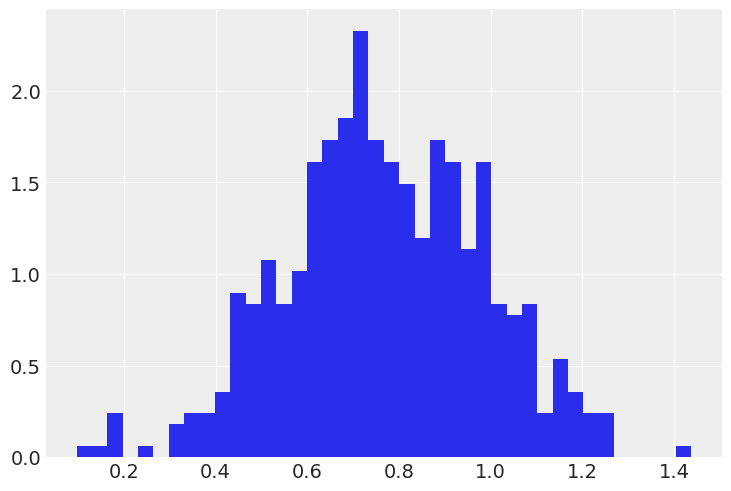

In [3]:
slearner_xgb.plot()

Eventough, the S-learner performs quite well in our synthetic example, it has some limitations. Most importantly, since the treatement indicator is included in the regression as an ordinary variable, it's effect may get lost, especially if the base learner is a tree based ensemble.

## T-learner

The *T-learner* solves the issue mentioned above by predicting $Y(0)$ and $Y(1)$ in two different regressions. Namely, we estimate
$$\mu_{\operatorname{treated}}(x) := \mathbb{E}[Y(1) \mid X=x], \quad \text{and} \quad \mu_{\operatorname{untreated}}(x) := \mathbb{E}[Y(0) \mid X=x]$$
separately and define estimate the cate as 
$$\hat{\tau}_T(x) = \mu_{\operatorname{treated}}(x) - \mu_{\operatorname{untreated}}(x).$$ 

In [10]:
from skl_meta_learners import TLearner

tlearner_xgb = TLearner(X=X_train, y=y_train, treated=treated_train, model=XGBRegressor())


tlearner_xgb.summary(n_iter=100)
print(f"Actual average treatement effect: {effect_train.mean()}")
print(f"EMSE: {mean_squared_error(effect_train, tlearner_xgb.cate)}")

Number of observations:             500
Number of treated observations:     260
Average treatement effect (ATE):    0.7737631797790527
95% Confidence interval for ATE:    (0.39325197115540506, 1.380606359243393)
Estimated bias:                     0.0014979877742007375
Actual average treatement effect: 0.8166310319237063
EMSE: 0.10909539371677517


# X-learner
The X-learner ...

In [11]:
from skl_meta_learners import XLearner

xlearner_xgb = XLearner(X=X_train, y=y_train, treated=treated_train, model=XGBRegressor())


xlearner_xgb.summary(n_iter=100)
print(f"Actual average treatement effect: {effect_train.mean()}")
print(f"EMSE: {mean_squared_error(effect_train, xlearner_xgb.cate)}")

Number of observations:             500
Number of treated observations:     260
Average treatement effect (ATE):    0.7781170069093923
95% Confidence interval for ATE:    (0.5208629256497909, 1.211836616459581)
Estimated bias:                     0.005161760576251569
Actual average treatement effect: 0.8166310319237063
EMSE: 0.06922727984762232


# DR-learner
The DR-learner ...

In [12]:
from skl_meta_learners import DRLearner

drlearner_xgb = DRLearner(X=X_train, y=y_train, treated=treated_train, model=XGBRegressor())


drlearner_xgb.summary(n_iter=100)
print(f"Actual average treatement effect: {effect_train.mean()}")
print(f"EMSE: {mean_squared_error(effect_train, drlearner_xgb.cate)}")

Number of observations:             500
Number of treated observations:     260
Average treatement effect (ATE):    0.7738259434700012
95% Confidence interval for ATE:    (0.38628790229558946, 1.3743409484624864)
Estimated bias:                     -0.002300022169947624
Actual average treatement effect: 0.8166310319237063
EMSE: 0.10963045326355204


In [19]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor

In [22]:
def compute_emse(learner, m):
    l = learner(X_train, y_train, treated_train, m)
    return mean_squared_error(effect_train, l.cate)

In [26]:
models = [
    ("Random forest", RandomForestRegressor()),
    ("Hist gradient boosting", HistGradientBoostingRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("XGBoost", XGBRegressor()),
    ("LightGBM", LGBMRegressor())
]
bench = pd.DataFrame({
    m_name: {
            'SLearner':  compute_emse( SLearner, m),
            'TLearner':  compute_emse( TLearner, m),
            'XLearner':  compute_emse( XLearner, m),
            'DRLearner': compute_emse(DRLearner, m)
        } for m_name, m in models
})

In [27]:
bench

,Random forest,Hist gradient boosting,AdaBoost,XGBoost,LightGBM
SLearner,0.043266,0.028720,0.005436,0.048527,0.030729
TLearner,0.045308,0.055968,0.011586,0.109095,0.052863
XLearner,0.027551,0.042998,0.008828,0.069227,0.041362
DRLearner,0.164998,0.179821,0.279397,0.109630,0.184410


# TODO: EMSE as a function of population size